#Time Series Classification

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

In [14]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [15]:
#Importing the data
normal = pd.read_csv('ptbdb_normal.csv',header = None)
abnormal = pd.read_csv('ptbdb_abnormal.csv', header = None)

In [16]:
normal.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
normal.shape

(4046, 188)

In [18]:
abnormal.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
abnormal.shape

(10506, 188)

In [20]:
data = pd.concat([normal, abnormal])

In [21]:
#Extracting NxT dimension from the data
X = data[data.columns[0:-1]].values

#Extracting labels
y = data[data.columns[-1]].values

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(11641, 187)
(2911, 187)


In [22]:
#Reshaping to NxTxD

N_train = X_train.shape[0]
D = 1
T = X_train.shape[1]
N_test = X_test.shape[0]

X_train = X_train.reshape(N_train,T,D) # N x T x D
X_test = X_test.reshape(N_test,T,D)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11641, 187, 1)
(11641,)
(2911, 187, 1)
(2911,)


In [23]:
#Transform to tensor and use dataloader
# Convert to tensor
train_data = torch.tensor(X_train).float()
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test).float()
test_labels = torch.tensor(y_test).long()


# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=batchsize, drop_last=True)

In [24]:
#Observe train batches
for x,y in train_loader:
    break
print(x.shape)
print(y.shape)

torch.Size([32, 187, 1])
torch.Size([32])


In [25]:
#Observe test batches
for x,y in test_loader:
    break
print(x.shape)
print(y.shape)

torch.Size([32, 187, 1])
torch.Size([32])


In [26]:
#Creating the model
class LSTM_model(nn.Module):
  def __init__(self,input_size, num_hidden, num_layers):
    super().__init__()

    # Define  parameters

    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    num_directions = 2
    self.directions = num_directions

    # LSTM Layer

    self.lstm = nn.LSTM(input_size,num_hidden,num_layers, batch_first = True, bidirectional = True)

    # Output Layer

    self.fc = nn.Linear(num_directions * num_hidden, 2)

  def forward(self,x):

    initial_h = torch.zeros(self.directions*self.num_layers, batchsize, self.num_hidden).to(device)
    initial_c = torch.zeros(self.directions*self.num_layers, batchsize, self.num_hidden).to(device)

    output, (h,c) = self.lstm(x, (initial_h, initial_c))

    # All the steps below are used to find the outputs both in forward and reverse direction,
    # then cancatenate both the outputs and then pass the concatenated output to the classification layer
    # to get the classification

    output_new = output.view(batchsize, T, self.directions, self.num_hidden)
    output_new_forward = output_new[:, :, 0, :]
    output_new_backward = output_new[:, :, 1, :]
    output_new_forward_piece = output_new_forward[:,-1,:]
    output_new_backward_piece = output_new_backward[:,0,:]
    output_final = torch.cat((output_new_forward_piece, output_new_backward_piece),1)
    output_final = self.fc(output_final)
    return output_final

In [27]:
#Set parameters
input_size  =  D     # D
hidden_size = 200
num_layers  =  1
seqlength   = T      # T

#Create Instance
Bi_lstmModel = LSTM_model (input_size, hidden_size, num_layers)

In [28]:
#Training and Testing
epochs = 100


# Loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(Bi_lstmModel.parameters(), momentum = 0.9, lr = 0.01)

Bi_lstmModel.to(device) # placing a model on GPU

  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 Bi_lstmModel.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = Bi_lstmModel(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 Bi_lstmModel.eval()

 with torch.no_grad():

    for X,y in test_loader:

            X = X.to(device)
            y = y.to(device)


            ypred =  Bi_lstmModel(X)
            ypred = ypred.cpu()
            y = y.cpu()

 testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
 if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')


 epochs : 0  loss :  0.65
 epochs : 10  loss :  0.54
 epochs : 20  loss :  0.65
 epochs : 30  loss :  0.31
 epochs : 40  loss :  0.22
 epochs : 50  loss :  0.19
 epochs : 60  loss :  0.15
 epochs : 70  loss :  0.17
 epochs : 80  loss :  0.04
 epochs : 90  loss :  0.01


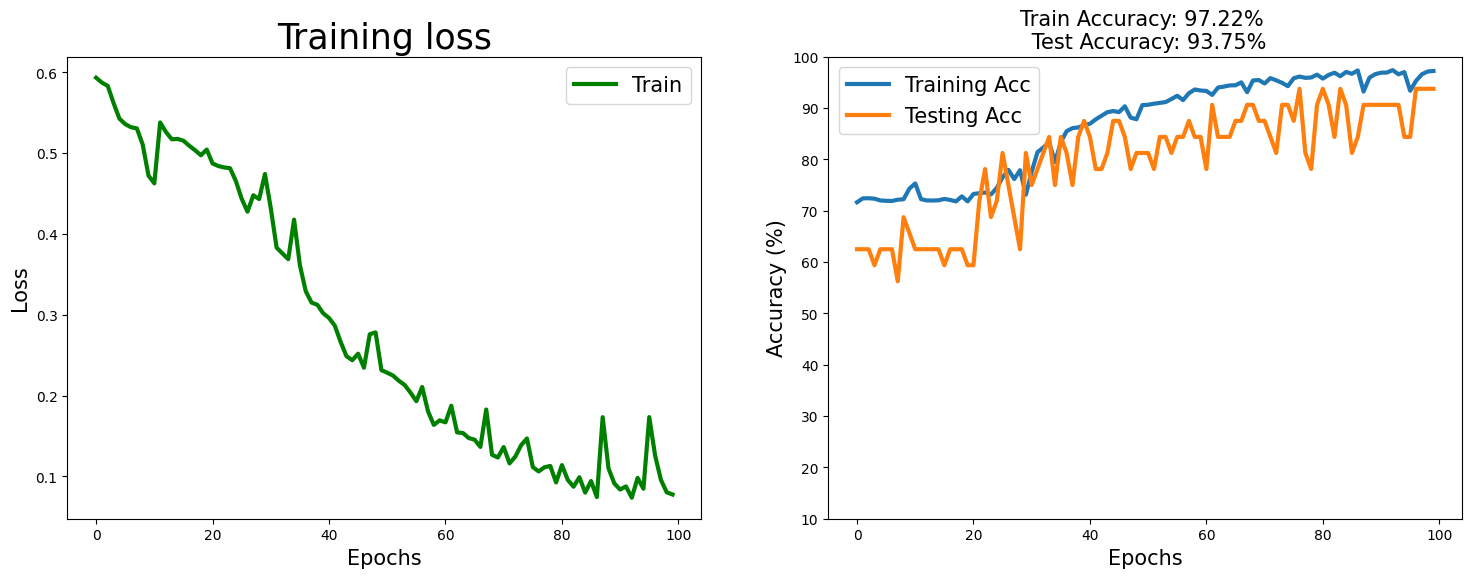

In [29]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()